In [2]:
import os, json

In [3]:
from tqdm import *
import time

In [4]:
import sys
sys.path.append('LLMs-Planning/llm_planning_analysis')

In [5]:
from Executor import Executor

In [6]:
data_path = "LLMs-Planning/llm_planning_analysis/instances/blocksworld/generated_basic"

In [7]:
import sys
sys.path.append("gpt-plan-benchmark/gpt_plan_test")
from Executor import Executor
# from reasoners.benchmark.bw_utils import *
from utils import *
from pathlib import Path
from tarski.io import PDDLReader

In [8]:
def get_problem(instance, domain):
    reader = PDDLReader(raise_on_error=True)
    reader.parse_domain(domain)
    return reader.parse_instance(instance)
def get_executor(instance, domain):
    plan_executor = Executor(domain, instance)
    return plan_executor
def compute_plan(domain, instance, timeout=30):
    fast_downward_path = os.getenv("FAST_DOWNWARD")
    # Remove > /dev/null to see the output of fast-downward
    assert os.path.exists(f"{fast_downward_path}/fast-downward.py")
    '''
    cmd = f"{fast_downward_path}/fast-downward.py --log-level debug --translate {domain} {instance} > /dev/null 2>&1"
    os.system(cmd)
    time.sleep(0.5)
    cmd = f"{fast_downward_path}/fast-downward.py --log-level debug output.sas --search-options --search  \"astar(lmcut())\" > /dev/null 2>&1" 
    os.system(cmd)
    time.sleep(0.5)
    '''
    if os.path.exists("sas_plan"):
        try:
            os.remove("sas_plan")
        except Exception as e:
            print(e)

    while not os.path.exists("sas_plan"):
        cmd = f"timeout {timeout}s {fast_downward_path}/fast-downward.py --log-level debug {domain} {instance} --search \"astar(lmcut())\"  > /dev/null 2>&1"
        # print(cmd)
        os.system(cmd)
        time.sleep(2)
        
    
    if not os.path.exists("sas_plan"):
        print("Plan failed")
        return ""
    
    return Path("sas_plan").read_text()

In [9]:
config_file = "examples/rap_blocksworld/data/bw_config.yaml"

In [10]:
import yaml
def read_config(config_file):
    with open(config_file, 'r') as file:
        data = yaml.safe_load(file)
    return data

In [11]:
domain_pddl = "examples/rap_blocksworld/data/generated_domain.pddl"

In [12]:
data = read_config(config_file)

In [13]:
import re
# re.findall("\(.*?\)", "(cc d), (ds)")

In [14]:
from tqdm import *
my_data = []
for i in tqdm(os.listdir(data_path)):
    if i.endswith(".pddl"):
        data_file = os.path.join(data_path, i)
        # print(i)
    else:
        print("Not pddl file", i)
        continue
    cur_instance = data_file
    problem = get_problem(cur_instance, domain_pddl)
    gt_plan = compute_plan(domain_pddl, cur_instance)
    gt_plan_text = get_plan_as_text(data)
    break
    my_data.append((cur_instance, gt_plan_text, len(re.findall("\(.*?\)", gt_plan_text))))

  0%|          | 0/501 [00:02<?, ?it/s]


In [18]:
val_path = os.getenv("VAL")
cmd = f"{val_path}/validate -v {domain_pddl} {cur_instance} sas_plan"
response = os.popen(cmd).read()

In [20]:
print(response)

Checking plan: sas_plan
Plan to validate:

Plan size: 10
1:
(unstack a c)
 
2:
(put-down a)
 
3:
(unstack c d)
 
4:
(stack c a)
 
5:
(unstack d b)
 
6:
(put-down d)
 
7:
(unstack c a)
 
8:
(stack c d)
 
9:
(pick-up b)
 
10:
(stack b c)
 

Plan Validation details
-----------------------

Checking next happening (time 1)
Deleting (on a c)
Deleting (clear a)
Deleting (handempty)
Adding (holding a)
Adding (clear c)

Checking next happening (time 2)
Deleting (holding a)
Adding (clear a)
Adding (handempty)
Adding (ontable a)

Checking next happening (time 3)
Deleting (on c d)
Deleting (clear c)
Deleting (handempty)
Adding (holding c)
Adding (clear d)

Checking next happening (time 4)
Deleting (clear a)
Deleting (holding c)
Adding (handempty)
Adding (clear c)
Adding (on c a)

Checking next happening (time 5)
Deleting (on d b)
Deleting (clear d)
Deleting (handempty)
Adding (holding d)
Adding (clear b)

Checking next happening (time 6)
Deleting (holding d)
Adding (clear d)
Adding (handempty)
Ad

In [15]:
domain_pddl

'/data/shibo/LLM-search/examples/rap_blocksworld/data/generated_domain.pddl'

In [19]:
print(cur_instance)

/data/shibo/LLM-search/LLMs-Planning/llm_planning_analysis/instances/blocksworld/generated_basic/instance-131.pddl


In [17]:
gt_plan_text

'(unstack a c)\n(put-down a)\n(unstack c d)\n(stack c a)\n(unstack d b)\n(put-down d)\n(unstack c a)\n(stack c d)\n(pick-up b)\n(stack b c)\n'

In [22]:
data_path_sup = "LLMs-Planning/llm_planning_analysis/instances/blocksworld/generated_basic_3"

In [23]:
from tqdm import *
my_data_sup = []
for i in tqdm(os.listdir(data_path_sup)):
    if i.endswith(".pddl"):
        data_file = os.path.join(data_path_sup, i)
        # print(i)
    else:
        print("Not pddl file", i)
        continue
    cur_instance = data_file
    problem = get_problem(cur_instance, domain_pddl)
    gt_plan = compute_plan(domain_pddl, cur_instance)
    gt_plan_text = get_plan_as_text(data)
    my_data_sup.append((cur_instance, gt_plan_text, len(re.findall("\(.*?\)", gt_plan_text))))

100%|██████████| 101/101 [03:35<00:00,  2.13s/it]


In [25]:
len(my_data)

501

In [26]:
len(my_data_sup)

101

In [27]:
import json

In [28]:
json.dump(my_data, open("bw_basic.json", "w"))
json.dump(my_data_sup, open("bw_basic_sup.json", "w"))

In [30]:
json.dump(my_data + my_data_sup, open("full", "w"))

In [31]:
under_8 = [d for d in my_data + my_data_sup if d[-1] <= 8]

In [35]:
under_6 = [d for d in my_data + my_data_sup if d[-1] <= 6]

In [36]:
print(len(under_8))
print(len(under_6))

441
288


In [37]:
json.dump(under_8, open("under_8.json", "w"))
json.dump(under_6, open("under_6.json", "w"))

In [ ]:
# Reproduce Haotian's 100% results
# CUDA_VISIBLE_DEVICES=2,3 python examples/rap_blocksworld/inference.py --data_path 'examples/rap_blocksworld/data/step_4.json' --depth_limit 4 --model_dir $LLAMA2_CKPTS --lora_dir None --batch_size 1 --output_trace_in_each_iter --mem_map [16,22]

# CUDA_VISIBLE_DEVICES=4,5 python examples/rap_blocksworld/inference.py --data_path 'examples/rap_blocksworld/data/under_6.json' --depth_limit 6 --model_dir $LLAMA2_CKPTS --lora_dir None --batch_size 1 --output_trace_in_each_iter --mem_map [16,22] --n_iters 20



In [2]:
import json

In [3]:
all_data = json.load(open("examples/rap_blocksworld/data/full.json", "r"))

In [5]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 68.0 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 101.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 81.4 MB/s eta 0:00:00


(array([ 47.,  86., 155., 153., 113.,  46.,   1.,   1.]),
 array([ 2.  ,  3.75,  5.5 ,  7.25,  9.  , 10.75, 12.5 , 14.25, 16.  ]),
 <BarContainer object of 8 artists>)

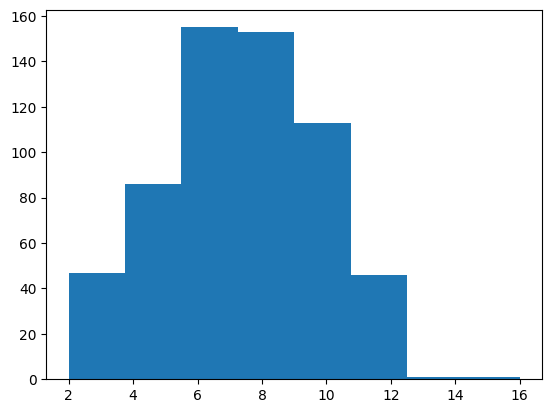

In [8]:
import matplotlib.pyplot as plt
plt.hist([d[-1] for d in all_data], bins=8)

In [7]:
for i in range(2, 30, 2):
    step_data = [d for d in all_data if d[-1] == i]
    if len(step_data) == 0:
        continue
    json.dump(step_data, open(f"examples/rap_blocksworld/data/new_data/step_{i}.json", "w"))
    print(len(step_data))

47
86
155
153
113
46
1
1
